In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import os
import copy
import time
import csv

from agent import PPO
from env import Flowsheet
from Simulation import *

In [2]:
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.plot(x,scores, alpha=0.2)
    plt.title('Running average of previous 100 scores')

C:\Users\hiyar\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode 1 total steps 7 avg score -8.4136 score:-8.41 
M1: [30.0000001, 1.0, 124.15, 258.78, 13.62, 0.0]
HX1: [663.6159957647324, [663.615996, 34.1652708, 124.15, 258.78, 13.62, 0.0]]
AR1: [1.5713500082492828, 9.067055150866508, [815.794871, 34.1652708, 0.000812358315, 134.630812, 137.769188, 124.149188]]
C1: [36.91133260726929, [36.9113326, 34.1652708, 0.000812358315, 134.630812, 137.769188, 124.149188]]
FR1: [20.28277924656868, 19.842436909675598, 0.6268481820821762, [20.2827792, 19.8424369, 0.384367766, 335.927688, 101.659873, 1.15212619], [20.2827792, 19.8424369, 65.1174774, 1.03850092e-05, 11.9049566, 58.1180064]]
PDC1: [9, 12.855459800292588, [-221.350817, 19.8424369, 0.0755504176, 1.03850092e-05, 11.9049566, 0.874942429], [248.525265, 19.8424369, 65.041927, 3.19176703e-34, 7.7895474e-08, 57.2430639]]
Episode 2 total steps 22 avg score -10.5327 score:-12.65 
M1: [30.0000001, 1.0, 124.15, 258.78, 13.62, 0.0]
HX1: [602.2542709112167, [602.254271, 35.1645163, 124.15, 258.78, 13.62, 

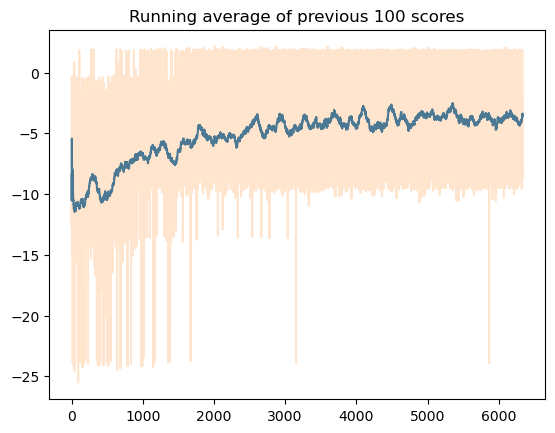

In [3]:
global sim, score_history

def main():
    global sim, score_history
    cwd = os.getcwd()
    sim = Simulation("BZN_prod.bkp", cwd)


    env_kwargs = {
            "sim": sim,
            "pure": 0.99, 
            "max_iter": 15, 
            "inlet_specs": [30.0, 1, {"BZN": 0, "METHANE": 13.62, "HYDROGEN": 258.78, "TOL": 124.15}]
        }

    env = Flowsheet(**env_kwargs)

    random_seed = 50
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    env.seed(random_seed)
   

    # Hyperparameters
    kwargs = {
        "state_dim": env.observation_space.shape[0], 
        "actions": env.action_space, 
        "env_with_Dead": True,
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
        "policy_clip": 0.2, 
        "n_epochs": 10, 
        "net_width": 64, 
        "lr": 2.5e-4, 
        "l2_reg": 0.5, 
        "batch_size": 64, 
        "entropy_coef": 0.025,
        "adv_normalization": True, 
        "entropy_coef_decay": 0.9
    }


    N = 512 # lenth of long trajectory
    Max_train_steps = int(50000)
    best_interval = int(10000)
    score_history = []


    total_steps = 0
    traj_length = 0
    episode = 1
    best_score = -100
    
    
    model = PPO(**kwargs)

    if not os.path.exists('model'): 
        os.mkdir('model')
    
    if not os.path.exists('best_model'): 
        os.mkdir('best_model')
    
    update = 0
    num_updates = Max_train_steps // N
    
    while total_steps < Max_train_steps:
        (observation, sin), done, steps, score = env.reset(), False, 0, 0
        
        mask_vec = env.action_masks(sin, True)

        '''Interact & trian'''
        while not done:
            steps += 1
            traj_length += 1
            total_steps += 1

            action_d, probs_d, action_c, probs_c = model.select_action(observation, mask_vec)
            action = {
                "discrete": action_d,
                "continuous": action_c}
            
            # Sometimes ASPEN bugs and fails to read information
            try:
                observation_, reward, done, info, sin = env.step(action, sin)

                if (done and steps != env.max_iter):
                    dw = True  #dw: dead and win
                else:
                    dw = False

                model.put_data((observation, action_d, action_c, reward, observation_, probs_d, probs_c, done, dw, mask_vec))
                observation = observation_
                mask_vec = env.action_masks(sin)
                score += reward 
                
                if traj_length % N == 0:
                    a,b,c = model.train()
                    traj_length = 0
                    update += 1
                    
                    frac = 1.0 - (update - 1.0) / num_updates
                    lrnow = frac * kwargs["lr"]
                    model.actor.optimizer.param_groups[0]["lr"] = lrnow
                    model.critic.optimizer.param_groups[0]["lr"] = lrnow

                    model.save(update)
            
            except:
                print("Error happened when reading data")
                done = True
                
        
        
        
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        # Save values of rewards
        f = open('rewards_file', 'a')
        writer = csv.writer(f, lineterminator = '\n')
        writer.writerow([avg_score])
        f.close()


        print('Episode {} total steps {} avg score {:.4f} score:{:.2f} '.
              format(episode, total_steps, avg_score, score))
        episode += 1

        env.render()
        
              
        ''' best model '''
        if total_steps >= best_interval:
            if score_history[-1] > best_score:
                best_score = score_history[-1]
                model.best_save()

if __name__ == '__main__':
    start_time = time.time()
    try:
        main()
    except:
        print("Error")
        sim.CloseAspen()
    
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history)

    end_time = time.time()
    final_time = end_time - start_time
    print(final_time)

In [4]:
global sim, score_history
mask = True
env_kwargs = {
    "sim": sim,
    "pure": 0.99, 
    "max_iter": 15, 
    "inlet_specs": [30.0, 1, {"BZN": 0, "METHANE": 13.62, "HYDROGEN": 258.78, "TOL": 124.15}]
}

env = Flowsheet(**env_kwargs)

# Hyperparameters
kwargs = {
    "state_dim": env.observation_space.shape[0], 
    "actions": env.action_space, 
    "env_with_Dead": True,
    "gamma": 0.99, 
    "gae_lambda": 0.95, 
    "policy_clip": 0.2, 
    "n_epochs": 10, 
    "net_width": 64, 
    "lr": 2.5e-4, 
    "l2_reg": 0.5, 
    "batch_size": 64, 
    "entropy_coef": 0.025,
    "adv_normalization": True, 
    "entropy_coef_decay": 0.9
}

model = PPO(**kwargs)

model.load_best()
scores = []

for i in range(1):
    obs, sin = env.reset()
    actions = []
    score = 0
    mask_vec = env.action_masks(sin, True)
    while True:
        action_d, action_c = model.evaluate(obs, mask_vec)
        action = {
                "discrete": action_d,
                "continuous": action_c }
        obs, reward, done, info, sin = env.step(action, sin)
        mask_vec = env.action_masks(sin)
        score += reward
        actions.append(action)

        if done:
            print(f"Done, points: {score}")
            env.render()
            break
    
    scores.append(score)

print(f"Mean score: {np.mean(scores)}")

sim.CloseAspen() 

C:\Users\hiyar\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\hiyar\My study\trial\0205\1\agent.py:288: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Done, points: 1.7312189977245676
M1: [30.0000001, 1.0, 124.15, 258.78, 13.62, 0.0]
HX1: [672.3181091547012, [672.318109, 34.8455952, 124.15, 258.78, 13.62, 0.0]]
AR1: [2.6885071396827698, 9.935643196105957, [824.174944, 34.8455952, 0.0, 134.628089, 137.771911, 124.151911]]
C1: [28.74860167503357, [28.7486017, 34.8455952, 0.0, 134.628089, 137.771911, 124.151911]]
FR1: [22.481721222400665, 17.70341256260872, 0.6044135332107544, [22.4817212, 17.7034126, 0.0, 205.703461, 179.910786, 2.64378292], [22.4817212, 17.7034126, 0.000956148655, 6.47767187e-06, 20.0171053, 122.418726]]
PDC1: [11, 23.252288062145997, [-220.889905, 17.7034126, 5.72631055e-07, 6.47767187e-06, 20.0171052, 3.23517584], [213.454327, 17.7034126, 0.000955576024, 4.77996214e-36, 1.3458126e-07, 119.18355]]
DCR2: [15, 106.1320948600769, 0.6098436407744885, [61.1130739, 1.0, 0.000166751419, 0.0, 0.616400808, 105.515527], [79.7139567, 1.0, 0.0162073522, 0.0, 6.98662061e-20, 26.4456038]]
Mean score: 1.7312189977245676
